# Задание 1. A/B–тестирование

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:
- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).
- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Импортируем необходимые для работы библиотеки, напишем функцию для загрузки данных и воспользуемся ей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
import scipy.stats as stats
import pandahouse as ph

%matplotlib inline

In [2]:
def upload_data(public_key, delimeter):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=delimeter)

In [3]:
groups = upload_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';')
groups_add = upload_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ',')
active_studs = upload_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ' ')
checks = upload_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';')

Проведем EDA. Для этого рассмотрим каждый датафрейм подробнее.

In [4]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
groups.duplicated().sum() 

0

In [7]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
groups_add.duplicated().sum() 

0

In [10]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [12]:
active_studs.duplicated().sum() 

0

In [13]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [14]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [15]:
checks.duplicated().sum()

0

Посмотрели на структуру данных, выяснили, что нет пропусков и дубликатов. Переходим к дальнейшему анализу.  
Для дальнейшей работы нам необходимо объединить два датафрейма: **groups** и **groups_add.**

In [16]:
total_groups = pd.concat([groups, groups_add])
total_groups = total_groups.reset_index(drop=True)

In [17]:
total_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Посмотрим, как распределены пользователи по группам.

In [18]:
total_groups['grp'].value_counts()

B    59883
A    14693
Name: grp, dtype: int64

У нас есть датафрейм **active_studs**, в котором информация о пользователях, зашедших на платформу в дни проведения эксперимента. Также есть датафрейм **checks**, который содержит информацию об оплатах пользователей в дни проведения эксперимента. Может случиться ситуация, что пользователь совершил оплату, но не был активен в дни проведения эксперимента. Это может быть связано, например, с автоматическим платежами, они сейчас очень распространены. Такие данные нельзя использовать, они будут искажать выводы. Проверим такой исход.

In [19]:
active_student_id = list(active_studs['student_id'])

In [20]:
checks_student_id = list(checks['student_id'])

In [21]:
inactive_student_id = list(set(checks_student_id) - set(active_student_id))

In [22]:
len(inactive_student_id)

149

**inactive_student_id** содержит **student_id**, которые есть в **checks_student_id**, но отсутствуют в **active_student_id.** Таким образом мы получили список пользователей, которые в период эксперимента совершили оплату, но не были активными. Количество таких пользователей равняется 149. Для дальнейшей работы необходимо убрать из данных этих пользователей.

In [23]:
total_groups.query('id in @inactive_student_id')

,id,grp
39,3185,B
121,25973,B
125,26280,B
223,100645,B
254,102534,B
...,...,...
72452,5291900,B
72753,5331842,B
73632,5486319,B
74049,5562806,B


Убедились в том, что неактивные пользователи есть в датафрейме о принадлежности пользователя к контрольной или экспериментальной группе, поэтому их точно нужно удалить.

In [24]:
total_groups = total_groups.query('id not in @inactive_student_id')

In [25]:
total_groups.query('id in @inactive_student_id')

,id,grp


Все, успешно очистили данные от неактивных пользователей.  
Теперь создадим два датафрейма: **total_active** - все активные пользователи, **total_active_paid** - активные пользователи, совершившие оплату.

In [26]:
total_groups = total_groups.rename(columns={'id': 'student_id'})

In [27]:
total_active = pd.merge(total_groups, active_studs, on='student_id', how='inner')

In [28]:
total_active_paid = pd.merge(total_active, checks, on='student_id', how='inner')

Text(0, 0.5, 'Кол-во клиентов')

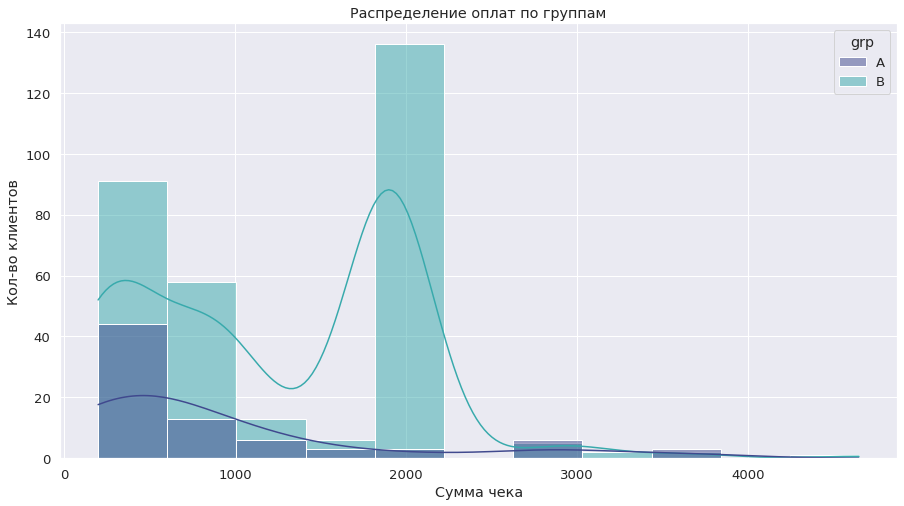

In [29]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.2)
sns.histplot(data=total_active_paid, x='rev', hue='grp', palette='mako', kde=True)
plt.title('Распределение оплат по группам')
plt.xlabel('Сумма чека')
plt.ylabel('Кол-во клиентов')

Для анализа эксперимента будут использоваться следующие метрики:
- CR - конверсия в оплату (число активных пользователей, совершивших оплату, к общему числу активных пользователей)
- ARPU - общая сумма платежей к количеству активных пользователей
- ARPPU - общая сумма платежей к количеству активных оплативших пользователей

Разделим пользователей на группы.

In [30]:
active_a = total_active.query('grp == "A"')
active_b = total_active.query('grp == "B"')
active_paid_a = total_active_paid.query('grp == "A"')
active_paid_b = total_active_paid.query('grp == "B"')

Рассчитаем метрики.

In [31]:
cr_a = round((active_paid_a.shape[0] / active_a.shape[0]) * 100, 2)
cr_b = round((active_paid_b.shape[0] / active_b.shape[0]) * 100, 2)
delta_cr = round(abs((cr_b - cr_a) / cr_a) * 100, 2)
print('CR у группы A:', cr_a, '\nCR у группы B:', cr_b)
if cr_a > cr_b:
    print('CR у группы A на', delta_cr, '% больше, чем у группы B\n')
else:
    print('CR у группы B на', delta_cr, '% больше, чем у группы A\n')

arpu_a = round(active_paid_a['rev'].sum() / active_a.shape[0], 2)
arpu_b = round(active_paid_b['rev'].sum() / active_b.shape[0], 2)
delta_arpu = round(abs((arpu_b - arpu_a) / arpu_a) * 100, 2)
print('ARPU у группы A:', arpu_a, '\nARPU у группы B:', arpu_b)
if arpu_a > arpu_b:
    print('ARPU у группы A на', delta_arpu, '% больше, чем у группы B\n')
else:
    print('ARPU у группы B на', delta_arpu, '% больше, чем у группы A\n')
    
arppu_a = round(active_paid_a['rev'].sum() / active_paid_a.shape[0], 2)
arppu_b = round(active_paid_b['rev'].sum() / active_paid_b.shape[0], 2)
delta_arppu = round(abs((arppu_b - arppu_a) / arppu_a) * 100, 2)
print('ARPPU у группы A:', arppu_a, '\nARPPU у группы B:', arppu_b)
if arpu_a > arpu_b:
    print('ARPPU у группы A на', delta_arppu, '% больше, чем у группы B')
else:
    print('ARPPU у группы B на', delta_arppu, '% больше, чем у группы A')

CR у группы A: 5.07 
CR у группы B: 4.62
CR у группы A на 8.88 % больше, чем у группы B

ARPU у группы A: 47.35 
ARPU у группы B: 58.06
ARPU у группы B на 22.62 % больше, чем у группы A

ARPPU у группы A: 933.59 
ARPPU у группы B: 1257.88
ARPPU у группы B на 34.74 % больше, чем у группы A


Как видно по результатам, конверсия в оплату у целевой группы уменьшилась, но ARPU и ARPPU увеличились. Посмотрим, статистически значимы ли различия метрик у групп.

### CR
Конверсия является номинативной переменной, т.е. делит людей на группы: оплатил или не оплатил. **Используем метод хи-квадрат.** Уровень значимости устанавливаем равным 0.05.  
**Гипотезы:  
H0 - конверсии в группах не отличаются.  
H1 - конверсии в группах отличаются.**

In [32]:
# добавим столбец paid в total_active, чтобы потом сделать таблицу сопряженности
total_active['paid'] = 0
total_active.loc[total_active['student_id'].isin(total_active_paid['student_id']), 'paid'] = 1

In [33]:
contingency_table = pd.crosstab(total_active['grp'], total_active['paid'])
contingency_table

paid,0,1
grp,,
A,1460,78
B,6489,314


In [34]:
statistic, pvalue, dof, expected_freq = stats.chi2_contingency(contingency_table)
print('p-value:', pvalue)

p-value: 0.48625240457231045


**p-value получилось > 0.05, поэтому принимаем нулевую гипотезу о том, что конверсии в группах не отличаются. Делаем вывод, что новая механика оплаты услуг на сайте не повлияла на конверсию.**

### ARPU
Сначала проверим распределение данных на нормальность.  
**Гипотезы:  
H0 - данные распределены нормально  
H1 - данные распределены ненормально**

In [35]:
arpu = total_active.merge(checks, on='student_id', how='left')
arpu = arpu.fillna(0)

In [36]:
stats.normaltest(arpu[arpu.grp == 'A'].rev)

NormaltestResult(statistic=2240.595797407402, pvalue=0.0)

In [37]:
stats.normaltest(arpu[arpu.grp == 'B'].rev)

NormaltestResult(statistic=7797.399211581946, pvalue=0.0)

**В двух группах p-value < 0.05, поэтому отвергаем нулевую гипотезу, данные распределены ненормально.**  
Теперь проверим равенство дисперсий в группах с помощью теста Левена.  
**Гипотезы:  
H0 - дисперсии внутри групп равны  
H1 - дисперсии внутри групп не равны**

In [38]:
stats.levene(arpu[arpu.grp == 'A'].rev, arpu[arpu.grp == 'B'].rev)

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

**p-value > 0.05, поэтому принимаем нулевую гипотезу, дисперсии внутри групп равны.**  
Таким образом получаем, что данные распределены ненормально, дисперсии гомогенны. **У нас большая выборка, поэтому даже при наличии ненормального распределения можно применить t-тест.**  
**Гипотезы:  
H0 - средние значения не отличаются в группах  
H1 - средние значения отличаются в группах**

In [39]:
stats.ttest_ind(arpu[arpu.grp == 'A'].rev, arpu[arpu.grp == 'B'].rev)

Ttest_indResult(statistic=-1.2253411073793445, pvalue=0.22048133326988378)

**p-value > 0.05, поэтому принимаем нулевую гипотезу, средние значения не отличаются в группах. Делаем вывод, что новая механика оплаты услуг на сайте не повлияла на ARPU.**

### ARPPU
Сначала проверим распределение данных на нормальность.  
**Гипотезы:  
H0 - данные распределены нормально  
H1 - данные распределены ненормально**

In [40]:
stats.normaltest(active_paid_a.rev)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

In [41]:
stats.normaltest(active_paid_b.rev)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

**В двух группах p-value < 0.05, поэтому отвергаем нулевую гипотезу, данные распределены ненормально.**  
Теперь проверим равенство дисперсий в группах с помощью теста Левена.  
**Гипотезы:  
H0 - дисперсии внутри групп равны  
H1 - дисперсии внутри групп не равны**

In [42]:
stats.levene(active_paid_a.rev, active_paid_b.rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Все аналогично ARPU: **p-value > 0.05, поэтому принимаем нулевую гипотезу, дисперсии внутри групп равны.**  
Таким образом получаем, что данные распределены ненормально, дисперсии гомогенны. **У нас большая выборка, поэтому даже при наличии ненормального распределения можно применить t-тест.**  
**Гипотезы:  
H0 - средние значения не отличаются в группах  
H1 - средние значения отличаются в группах**

In [43]:
stats.ttest_ind(active_paid_a.rev, active_paid_b.rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

**p-value < 0.05, поэтому отвергаем нулевую гипотезу, средние значения отличаются в группах. Делаем вывод, что новая механика оплаты услуг на сайте положительно повлияла на ARPPU, увеличив эту метрику.**

### Вывод
По итогам тестирования получены следующие результаты:
- новая механика оплаты услуг не повлияла на CR
- новая механика оплаты услуг не повлияла на ARPU
- новая механика оплаты услуг положительно повлияла на ARPPU

**В связи с тем, что новая механика оплаты услуг увеличила ARPPU, не ухудшив CR и ARPU, принимаем решение о запуске новой механики оплаты на всех пользователей.**

# Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".  
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Дана таблица default.peas  
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. **NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.**

In [44]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student',
                      'password': 'dpo_python_2020'}

Посмотрим на данные, хранящиеся в таблице peas.

In [45]:
query = """
select
    st_id,
    toDateTime(timest) as timest,
    correct,
    subject
from
    peas
"""

peas = ph.read_clickhouse(query, connection=connection_default)
peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability
...,...,...,...,...
13240,996911,2021-10-31 08:41:00,1,Statistics
13241,996911,2021-10-31 09:12:28,0,Statistics
13242,996911,2021-10-31 09:33:39,0,Statistics
13243,996911,2021-10-31 09:46:44,1,Statistics


In [46]:
query = """
with count_correct as (
    select
        st_id,
        count(correct) as count
    from
        peas
    where
        correct = 1
    group by
        st_id)

select
    count(st_id) as count_students
from
    count_correct
where
    count >= 20
"""

count_students = ph.read_clickhouse(query, connection=connection_default)
count_students

,count_students
0,136


**Количество очень усердных студентов - 136 человек.**

### 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: default.peas, default.studs и default.final_project_check.  
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.  
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.  
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Сначала посмотрим на данные двух новых таблиц - **studs** и **final_project_check.**

In [47]:
query = """
select
    *
from
    studs
"""

studs = ph.read_clickhouse(query, connection=connection_default)
studs

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot
...,...,...
595,988626,pilot
596,993249,pilot
597,994983,pilot
598,996911,control


In [48]:
query = """
select
    st_id,
    toDateTime(sale_time) as sale_time,
    money,
    subject
from
    final_project_check 
"""

check = ph.read_clickhouse(query, connection=connection_default)
check

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math
...,...,...,...,...
56,969595,2021-10-30 23:54:52,65000,Vizualization
57,969595,2021-10-31 02:02:07,75000,Statistics
58,969595,2021-10-31 10:07:04,100000,Python
59,976866,2021-10-30 16:20:17,85000,Math


In [49]:
query = """
with
    active_students as (
        select
            st_id,
            countIf(correct = 1) as total_active,
            countIf(correct = 1 and subject = 'Math') as math_active
        from
            peas
        group by
            st_id),
    
    revenue as (
        select
            st_id,
            sum(money) as total_revenue,
            sumIf(money, subject = 'Math') as math_revenue
        from
            final_project_check
        group by
            st_id)

select
    studs.test_grp as test_group,
    round(sum(revenue.total_revenue) / countDistinct(studs.st_id), 2) as ARPU,
    round(sumIf(revenue.total_revenue, active_students.total_active > 10) / countDistinctIf(studs.st_id, active_students.total_active > 10), 2) as ARPAU,
    round(countDistinctIf(revenue.st_id, revenue.total_revenue > 0) * 100 / countDistinct(studs.st_id), 2) as CR,
    round(countDistinctIf(active_students.st_id, revenue.total_revenue > 0 and active_students.total_active > 10) * 100 / countDistinctIf(active_students.st_id, active_students.total_active > 10), 2) as active_CR,
    round(countDistinctIf(active_students.st_id, revenue.math_revenue > 0 and active_students.math_active >= 2) * 100 / countDistinctIf(active_students.st_id, active_students.math_active >= 2), 2) as math_CR
from
    studs
left join
    active_students on studs.st_id = active_students.st_id
left join
    revenue on studs.st_id = revenue.st_id
group by
    studs.test_grp
"""

metrics = ph.read_clickhouse(query, connection=connection_default)
metrics

,test_group,ARPU,ARPAU,CR,active_CR,math_CR
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Напишем функцию **metrics**, которая на вход будет получать имеющиейся датафреймы и ссылку на доп файл groups_add, который загружается через API. Внутри функции заголовки переименовываются, но так как мы не знаем, какие у них могут быть названия, используем обращение к колонкам по индексам. Далее рассчитываются необходимые метрики, которые в конце собираются в датафрейм.

In [50]:
def metrics(groups, groups_add_url, active_studs, checks):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=groups_add_url)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    groups_add = pd.read_csv(download_url)
    
    groups_add = groups_add.rename(columns={groups_add.columns[0]: 'student_id', groups_add.columns[1]: 'grp'})

    groups = groups.rename(columns={groups.columns[0]: 'student_id'})
    
    total_groups = pd.concat([groups, groups_add])
    total_groups = total_groups.reset_index(drop=True)
    
    active_student_id = list(active_studs['student_id'])
    checks_student_id = list(checks['student_id'])
    inactive_student_id = list(set(checks_student_id) - set(active_student_id))
    
    total_groups = total_groups.query('student_id not in @inactive_student_id')
    
    total_active = pd.merge(total_groups, active_studs, on='student_id', how='inner')
    total_active_paid = pd.merge(total_active, checks, on='student_id', how='inner')
    
    active_a = total_active.query('grp == "A"')
    active_b = total_active.query('grp == "B"')
    active_paid_a = total_active_paid.query('grp == "A"')
    active_paid_b = total_active_paid.query('grp == "B"')
    
    cr_a = round((active_paid_a.shape[0] / active_a.shape[0]) * 100, 2)
    cr_b = round((active_paid_b.shape[0] / active_b.shape[0]) * 100, 2)
    
    arpu_a = round(active_paid_a['rev'].sum() / active_a.shape[0], 2)
    arpu_b = round(active_paid_b['rev'].sum() / active_b.shape[0], 2)
    
    arppu_a = round(active_paid_a['rev'].sum() / active_paid_a.shape[0], 2)
    arppu_b = round(active_paid_b['rev'].sum() / active_paid_b.shape[0], 2)
    
    metrics_df = pd.DataFrame({
        'group': ['A', 'B'],
        'CR': [cr_a, cr_b],
        'ARPU': [arpu_a, arpu_b],
        'ARPPU': [arppu_a, arppu_b]
    })
    
    return metrics_df

In [51]:
update_metrics = metrics(groups, 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', active_studs, checks)
update_metrics

,group,CR,ARPU,ARPPU
0,A,5.07,47.35,933.59
1,B,4.62,58.06,1257.88


In [52]:
def metrics_visualization(df):
    sns.set(font_scale=1.3)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.barplot(data=df, x='group', y='CR', palette='mako', ax=axes[0])
    axes[0].set_title('CR')
    
    sns.barplot(data=df, x='group', y='ARPU', palette='mako', ax=axes[1])
    axes[1].set_title('ARPU')
    
    sns.barplot(data=df, x='group', y='ARPPU', palette='mako', ax=axes[2])
    axes[2].set_title('ARPPU')
    
    plt.tight_layout()
    plt.show()

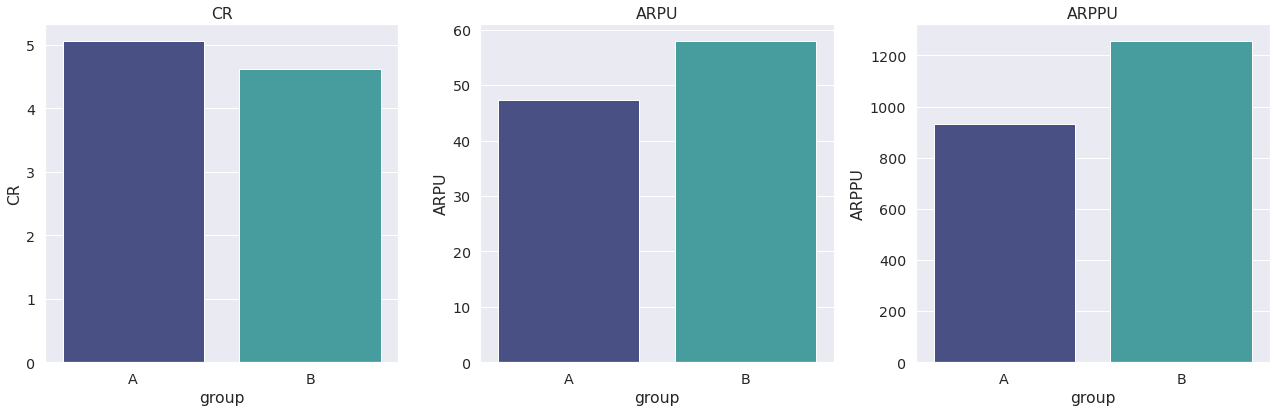

In [53]:
metrics_visualization(update_metrics)